### WGAN-GP overriding Model.train_step

Taken from keras.io/generative/wgan_gp/
Author: A_K_Nain
Description: Implementation of Wasserstein GAN with Gradient Penalty.

### Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import tensorflow as tf
from keras import layers

### Prepare the Fashion-MNIST data

In [9]:
IMG_SHAPE = (28, 28, 1)


noise_dim = 128
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5


Number of examples: 60000
Shape of the images in the dataset: (28, 28)


### Create the discriminator (the critic in the original WGAN)

In [19]:
def get_discriminator_model():
    img_input = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(img_input)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    return keras.Model(img_input, x, name="discriminator")

d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 64)          │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 7, 7, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 396,609 (1.51 MB)

 Trainable params: 396,609 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

### Create the Generator

In [10]:

def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))

    x = layers.Dense(7 * 7 * 128, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((7, 7, 128))(x)
    x = upsample_block(
        x, 128, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, use_bn=True
    )

    x = upsample_block(
        x, 64, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, use_bn=True
    )

    x = layers.Conv2D(1, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = layers.Activation("tanh")(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model

g_model = get_generator_model()
g_model.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6272)                │         802,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6272)                │          25,088 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 128)         │         147,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 1)           │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,050,432 (4.01 MB)

 Trainable params: 1,037,504 (3.96 MB)

 Non-trainable params: 12,928 (50.50 KB)

### Create the WGAN-GP model

In [11]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


### Create a Keras callback that periodically saves generated images

In [12]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.utils.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

### Train the end-to-end model

In [14]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0003, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0003, beta_1=0.5, beta_2=0.9
)


# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for training.
epochs = 30
BATCH_SIZE = 256
# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training
history = wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 82s 231ms/step - d_loss: -3.4650 - g_loss: -12.4971
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 49s 163ms/step - d_loss: -2.4014 - g_loss: -24.2486
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - d_loss: -1.8556 - g_loss: -16.4594
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - d_loss: -1.7314 - g_loss: -13.6698
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - d_loss: -1.6683 - g_loss: -12.2516
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - d_loss: -1.5827 - g_loss: -11.3116
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - d_loss: -1.5341 - g_loss: -10.3919
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - d_loss: -1.5008 - g_loss: -10.2227
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - d_loss: -1.4649 - g_loss: -8.3740
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - d_loss: -1.4305 - g_loss: -7.2205
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - d_loss: -1.4164 - g_los

### Display some images

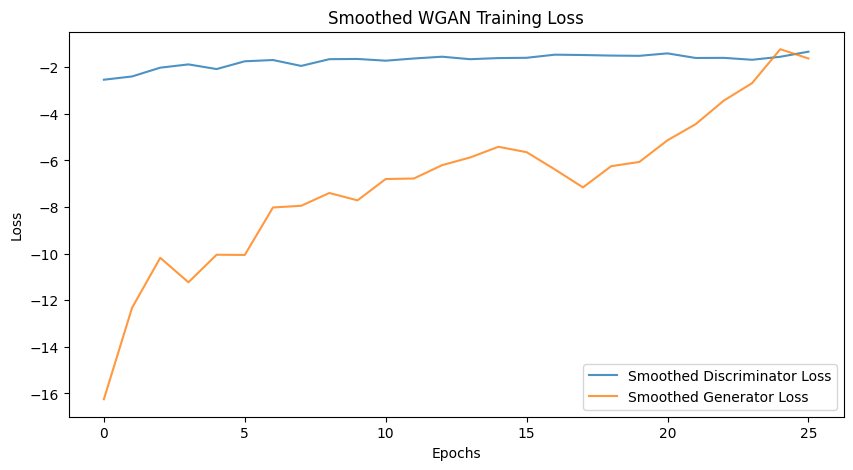

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Extract loss values from training history
d_loss = np.array(wgan.history.history["d_loss"])
g_loss = np.array(wgan.history.history["g_loss"])

# Function to smooth the loss curves
def smooth_curve(values, smooth_factor=5):
    smoothed = np.convolve(values, np.ones(smooth_factor)/smooth_factor, mode='valid')
    return smoothed

# Apply smoothing
smooth_d_loss = smooth_curve(d_loss, smooth_factor=5)
smooth_g_loss = smooth_curve(g_loss, smooth_factor=5)

# Plot the smoothed losses
plt.figure(figsize=(10, 5))
plt.plot(smooth_d_loss, label="Smoothed Discriminator Loss", alpha=0.8)
plt.plot(smooth_g_loss, label="Smoothed Generator Loss", alpha=0.8)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Smoothed WGAN Training Loss")
plt.legend()
plt.show()


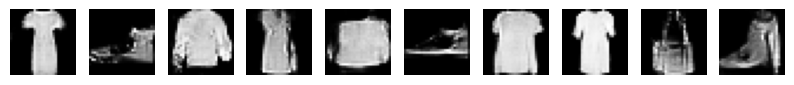

In [18]:
import matplotlib.pyplot as plt
import tensorflow as tf

num_samples = 10

random_latent_vectors = tf.random.normal(shape=(num_samples, noise_dim))

generated_images = wgan.generator(random_latent_vectors)

generated_images = (generated_images + 1) / 2.0

generated_images = tf.squeeze(generated_images, axis=-1)

fig, axes = plt.subplots(1, num_samples, figsize=(10, 4))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i], cmap="gray")
    ax.axis("off")

plt.show()


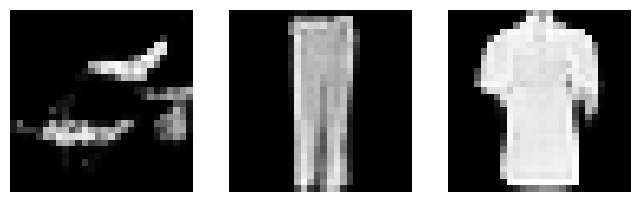

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
img1 = mpimg.imread("generated_img_0_50.png")
img2 = mpimg.imread("generated_img_1_50.png")
img3 = mpimg.imread("generated_img_2_50.png")

# Arrange in a row
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

axes[0].imshow(img1, cmap="gray")
axes[0].axis("off")

axes[1].imshow(img2, cmap="gray")
axes[1].axis("off")

axes[2].imshow(img3, cmap="gray")
axes[2].axis("off")

plt.show()
